# Pipeline Pembersihan Data Ulasan Game (Data Preprocessing)

Notebook ini bertanggung jawab untuk mengubah data mentah (raw text) dari ulasan Google Play Store menjadi data bersih yang siap "dimakan" oleh mesin.

**Tujuan:**
1. Membersihkan sampah karakter (emoji, simbol aneh).
2. Menormalisasi bahasa gaul/alay (contoh: "yg" -> "yang").
3. Menyamarkan entitas game (contoh: "Arknights" -> "[GAME_TITLE]") agar model bisa digunakan untuk game apa saja.
4. Melakukan *Stemming* (mengubah kata berimbuhan menjadi kata dasar).

---


## 1. Import Library & Setup Engine
Kita menggunakan **Sastrawi** untuk pemrosesan Bahasa Indonesia.

In [2]:
import pandas as pd
import re
import requests
import io
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from langdetect import DetectorFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [3]:
# Agar hasil deteksi bahasa konsisten
DetectorFactory.seed = 0 

# Setup Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
# Kita tambah manual stopwords yang sering muncul di chat tapi tidak sentimen
stopwords_indo = set(stop_factory.get_stop_words() + ['sih', 'nya', 'nih', 'tuh', 'dong', 'yang', 'dan', 'di', 'ini', 'itu'])

print("Library berhasil dimuat.")

Library berhasil dimuat.


## 2. Membangun "Kamus Pengetahuan"
Agar pembersihan akurat, kita butuh kamus. Kita menggunakan 3 jenis kamus:
1. **Kamus Alay:** Dari repo GitHub (ribuan kata gaul).
2. **Kamus Game:** Istilah spesifik gamer (AFK, Lag, Gacha).
3. **Kamus Entity:** Menyamarkan nama karakter/game spesifik.

In [4]:
# --- 1. LOAD KAMUS ALAY EKSTERNAL ---
def load_slang_dictionary():
    url = "https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv"
    print("Sedang mendownload Kamus Alay dari Github...")
    try:
        s = requests.get(url).content
        df_slang = pd.read_csv(io.StringIO(s.decode('utf-8')))
        # Buat dictionary: {'bs': 'bisa', ...}
        slang_dict = dict(zip(df_slang['slang'], df_slang['formal']))
        print(f"Berhasil memuat {len(slang_dict)} kata gaul standar!")
        return slang_dict
    except Exception as e:
        print(f"Gagal memuat kamus eksternal: {e}")
        return {}

# --- 2. KAMUS SPESIFIK GAME & INGGRIS-INDO ---
game_slang_dict = {
    # Inggris -> Indo (Mapping Sentimen)
    'good': 'bagus', 'bad': 'buruk', 'best': 'terbaik', 'worst': 'terburuk',
    'nice': 'bagus', 'love': 'suka', 'hate': 'benci', 'worth': 'layak',
    'event': 'acara', 'story': 'cerita', 'map': 'peta', 'design': 'desain', 
    'whale': 'sultan', 'pay': 'bayar', 'win': 'menang', 'login': 'masuk', 
    'stuck': 'macet', 'bug': 'rusak', 'error': 'rusak', 'love': 'suka',
    
    # Slang Gamer Indo
    'lag': 'lambat', 'lemot': 'lambat', 'patah': 'lambat', 'fps': 'lambat',
    'bgt': 'banget', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak',
    'g': 'tidak', 'tdk': 'tidak', 'jgn': 'jangan', 'n': 'dan',
    'dpt': 'dapat', 'bs': 'bisa', 'klo': 'kalau', 'udh': 'sudah',
    'sdh': 'sudah', 'apik': 'bagus', 'mantap': 'bagus', 'gacor': 'bagus',
    'wangi': 'beruntung', 'ampas': 'sial', 'zonk': 'sial',
    'comeback': 'kembali', 'char': 'karakter', 'chara': 'karakter',
    'fr': 'benar-benar', 'newbie': 'pemula', 'friendly': 'ramah',
    'f2p': 'gratisan', 'f p': 'gratisan', 'fp': 'gratisan'
}

# --- 3. MERGE KAMUS ---
final_norm_dict = load_slang_dictionary()
final_norm_dict.update(game_slang_dict) # Timpa dengan istilah game kita agar lebih prioritas

print(f"Total kosakata normalisasi: {len(final_norm_dict)} kata.")

Sedang mendownload Kamus Alay dari Github...
Berhasil memuat 4331 kata gaul standar!
Total kosakata normalisasi: 4370 kata.


In [5]:
# --- KAMUS ABSTRAKSI (ENTITY DICTIONARY) ---
game_entities = {
    '[GAME_TITLE]': [
        'arknights', 'nikke', 'wuthering waves', 'blue archive', 
        'zzz', 'zenless zone zero', 'reverse 1999', 'genshin', 'star rail', 'honkai'
    ],
    
    '[CURRENCY]': [
        'orundum', 'originium', 'lmd', 'gem', 'gems', 'jewel', 'credits',
        'polychrome', 'asterite', 'lunite', 'pyroxene', 'credit', 'primogem', 'crystal'
    ],

    '[RESOURCE]': [
        'sanity', 'stamina', 'energy', 'battery', 'serum', 'activity points', 'resin'
    ],

    '[CHARACTER]': [
        # --- ARKNIGHTS ---
        'amiya', 'chen', 'surtr', 'kaltsit', 'exusiai', 'silverash', 'skadi', 'texas', 'thorns', 'mudrock',
        'saria', 'lappland', 'w', 'rosmontis', 'ifrit', 'eyjafjalla', 'angelina', 'bagpipe', 'blaze', 'ceobe',
        'hoshiguma', 'nightingale', 'shining', 'siege', 'mostima', 'phantom', 'rosa', 'suzuran', 'weedy', 'aak',
        'mizuki', 'saileach', 'flametail', 'gnosis', 'lee', 'ling', 'fiammetta', 'horn', 'irene', 'lumen',
        'ebenholz', 'gavial', 'pozyomka', 'mlynar', 'penance', 'stainless', 'chongyue', 'lin', 'qiubai', 'ines',
        'hoolheyak', 'typhon', 'jessica', 'hoederer', 'viviana', 'degenbrecher', 'ray', 'shu', 'ela', 'wisadel',
        'logos', 'zuma', 'pepe', 'narantuya', 'ulpianus', 'red', 'gravel', 'jaye', 'myrtle', 'elysium',
        'specter', 'andreana', 'kafka', 'robin', 'pinecone', 'bubble', 'jackie', 'roberta', 'mulberry', 'honeyberry',
        'pudding', 'corroserum', 'rockrock', 'blacknight', 'kazemaru', 'enforcer', 'heidy', 'erato', 'greyy', 'hibiscus',
        'cantabile', 'paprika', 'totter', 'quartz', 'cement', 'dagda', 'steward', 'adnachiel', 'ansel', 'beagle',
        
        # --- NIKKE ---
        'rapi', 'anis', 'neon', 'modernia', 'scarlet', 'red hood', 'alice', 'dorothy', 'blanc', 'noir',
        'liter', 'privaty', 'rupee', 'marian', 'harran', 'snow white', 'rapunzel', 'noah', 'isabel', 'centi',
        'viper', 'jackal', 'crow', 'diesel', 'soline', 'brid', 'epinel', 'folkwang', 'mary', 'pepper',
        'miranda', 'signal', 'poli', 'eunhwa', 'emma', 'vesti', 'guillotine', 'maiden', 'drake', 'maxwell',
        'yuni', 'mihara', 'ludmilla', 'neve', 'tove', 'leona', 'moran', 'ade', 'elegg', 'd killer wife',
        'exia', 'novel', 'volume', 'aria', 'noise', 'dolla', 'yan', 'frima', 'sugar', 'milk',
        'laplace', 'helm', 'admi', 'liberty', 'quency', 'sin', 'guilty', 'nihilister', 'johan', 'cecil',
        'andersen', 'mustang', 'ingrid', 'syuen', 'burningum', 'shifty', 'enchikk', 'liveryn', 'kilo', 'rei',
        'marciana', 'naga', 'tia', 'tove', 'rosanna', 'sakura', 'nero', 'mast', 'anchor', '2b',
        'a2', 'pascal', 'clay', 'bay', 'tron', 'ein', 'zwei', 'cinderella', 'grave', 'chime',
        
        # --- BLUE ARCHIVE ---
        'shiroko', 'hoshino', 'yuuka', 'hina', 'mika', 'asuna', 'karin', 'aru', 'aris', 'azusa',
        'koharu', 'hanako', 'wakamo', 'seia', 'nonomi', 'serika', 'ayane', 'iori', 'chinatsu', 'hasumi',
        'tsurugi', 'mashiro', 'izumi', 'akari', 'haruna', 'junko', 'fuuka', 'juri', 'neru', 'akane',
        'maki', 'hibiki', 'utaha', 'kotori', 'noa', 'koyuki', 'momoi', 'midori', 'yuzu', 'cherino',
        'nodoka', 'shigure', 'hifumi', 'nagisa', 'saori', 'atsuko', 'misaki', 'hiyori', 'miyako', 'saki',
        'moe', 'miyu', 'kanna', 'kirino', 'fubuki', 'chihiro', 'himari', 'eimi', 'sumire', 'shun',
        'kokona', 'saya', 'kisaki', 'mina', 'rumi', 'minori', 'momiji', 'renge', 'kikyou', 'kasumi',
        'ichika', 'yukari', 'shuro', 'akira', 'kai', 'black suit', 'maestro', 'golconde', 'decalcomanie', 'beatrice',
        'phrenapates', 'plana', 'arona', 'rin', 'aoi', 'momoka', 'ayumu', 'sora', 'shinon', 'mai',
        
        # --- REVERSE: 1999 ---
        'vertin', 'sonetto', 'regulus', 'schneider', 'tooth fairy', 'voyager', 'bkornblume', 'sotheby', 'a knight', 'an-an lee',
        'kaalaa baunaa', 'jessica', 'druvis', 'lilya', 'eternity', 'medicine pocket', 'centurion', 'ms newbabel', 'shamane', 'black dwarf',
        'pickles', 'melania', 'diggers', 'tennant', 'dikke', 'balloon party', 'baby blue', 'charlie', 'x', 'satsuki',
        'necrologist', 'blonney', 'horropedia', '6', '37', 'spathodea', 'ezra', 'getian', 'yenisei', 'jiu niangzi',
        'isolde', 'marcus', 'vila', 'windsong', 'lucy', 'kakania', 'lorelei', 'semmelweis', 'matilda', 'onion',
        'apple', 'eagle', 'oliver fog', 'leilani', 'mondlicht', 'ttws', 'la source', 'pavia', 'zima', 'cristallo',
        'bette', 'nick bottom', 'rabies', 'mesmer jr', 'darley clatter', 'poltergeist', 'bunny bunny', 'fool', 'door', 'ms radio',
        'sputnik', 'alien t', 'john titor', 'arcana', 'constantine', 'z', 'madam z', 'mr karson', 'georgia', 'marianne',
        
        # --- WUTHERING WAVES ---
        'rover', 'jinhsi', 'yinlin', 'jiyan', 'changli', 'yangyang', 'chixia', 'baizhi', 'calcharo', 'verina',
        'encore', 'sanhua', 'jianxin', 'lingyang', 'danjin', 'mortefi', 'aalto', 'yuanwu', 'taoqi', 'zhezhi',
        'xiangli yao', 'camellya', 'phrolova', 'scar', 'geshu lin', 'jué', 'shorekeeper', 'youhu', 'lumi', 'yhan',
        'gull', 'uncle wei', 'xiaoyu', 'panhua', 'ganxue', 'jinheng', 'minghu', 'qingge', 'dayui', 'koko',
        'crownless', 'dreamless', 'bell-borne geochelone', 'inferno rider', 'mourning aix', 'tempest mephis', 'thundering mephis', 'feilian beringal', 'lampylumen myriad', 'impermanence heron',
        'mech abomination', 'havoc dreadmane', 'cyan-feathered heron', 'violet-feathered heron', 'hoartooth', 'carapace', 'viridblaze saurian', 'roseshoom', 'chirpuff', 'snip snap',
        'zigzag', 'whiff whaff', 'tick tack', 'glacio predator', 'fusion predator', 'aero predator', 'electro predator', 'havoc predator', 'spectro predator', 'cruisewing',
        'vanguard junrock', 'fission junrock', 'electro prism', 'glacio prism', 'fusion prism', 'havoc prism', 'spectro prism', 'aero prism', 'flautist', 'tambourinist',
        
        # --- ZENLESS ZONE ZERO ---
        'belle', 'wise', 'anby', 'nicole', 'billy', 'ellen', 'zhu yuan', 'lycaon', 'koleda', 'nekomata',
        'soldier 11', 'miyabi', 'soukaku', 'anton', 'ben', 'corin', 'qingyi', 'jane doe', 'seth', 'grace',
        'rina', 'lucy', 'piper', 'burnice', 'caesar', 'lighter', 'yanagi', 'harumasa', 'miyon', 'asha',
        'tin master', 'sjal', 'heddy', 'general chop', 'elfy', 'howl', 'enzo', 'casper', 'ray', 'fairy',
        'eou', 'butler', 'amillion', 'bagboo', 'safety', 'exploreboo', 'vigilant', 'sharkboo', 'penguinboo', 'booressure',
        'rocketboo', 'devilboo', 'luckyboo', 'paperboo', 'killion', 'fous', 'sumo', 'bangvolver', 'resonaboo', 'plugboo',
        'electroboo', 'cryoboo', 'pyrobo', 'etherboo', 'physicalboo', 'avocaboo', 'magnetiboo', 'officer cui', 'red moccasus', 'baddieboo',
        'dead end butcher', 'thanatos', 'dulahan', 'hollow raider', 'ethereal', 'unknown corruption', 'nineveh', 'friday', 'pulchra', 'bellum'
    ],

    '[FACTION]': [
        # --- ARKNIGHTS ---
        'rhodes island', 'reunion movement', 'penguin logistics', 'blacksteel worldwide', 'lungmen guard department', 'victoria', 'ursus student self-governing group', 'kazimierz', 'kjerag', 'rhine lab',
        'siesta', 'laterano', 'iberia', 'abyssal hunters', 'higashi', 'siracusa', 'columbia', 'sargon', 'bolivar', 'leithanien',
        'minos', 'yan', 'sui regulators', 'dublinn', 'rusthammer', 'yeti squadron', 'guerrilla shieldguards', 'neo-reunion', 'confessarius', 'military commission',
        'babylon', 'karlan trade', 'lee detective agency', 'glasgow gang', 'pinus sylvestris', 'followers', 'elite operators', 'sweep', 'reserve op team a1', 'reserve op team a4',
        'reserve op team a6', 'action team a4', 's.w.e.e.p', 'logistics department', 'medical department', 'engineering department', 'human resources', 'doctor office', 'control center', 'training room',
        
        # --- NIKKE ---
        'elysion', 'missilis industry', 'tetra line', 'pilgrim', 'abnormal', 'counters', 'absolute', 'matis', 'cafe sweety', 'mighty tools',
        'talentum', 'protocol', 'infinity rail', 'unlimited', 'carronades', 'acpu', 'perilous siege', 'exotic', 'real kindness', 'wardress',
        'maid for you', 'underworld queen', 'happy zoo', 'school circle', 'recall and release', 'seraphim', 'the scouts', 'triangle', 'aegis', 'extrinsic',
        'pioneer', 'inherert', 'white knights', 'heretics', 'raptures', 'central government', 'outer rim', 'royal road', 'ark', 'eden',
        
        # --- BLUE ARCHIVE ---
        'abydos high school', 'gehenna academy', 'trinity general school', 'millennium science school', 'shanhaijing senior secondary school', 'hyakkiyako alliance academy', 'red winter federal academy', 'valkyrie police school', 'arius branch school', 'srt special academy',
        'general student council', 'prefect team', 'problem solver 68', 'gourmet research society', 'justice realization committee', 'tea party', 'sisterhood', 'after-school sweets club', 'game development department', 'c&c',
        'seminar', 'veritas', 'engineering department', 'cleaning and clearing', 'remedial knights', 'make-up work club', 'rabbit squad', 'fox squad', 'pandemonium society', 'emergency medicine department',
        'festival operations department', 'inner discipline club', 'yin-yang club', 'mask of mizuhana', 'spec ops no 227', 'public safety bureau', 'labor party', 'knowledge liberation front', 'hot springs department', 'black market',
        
        # --- REVERSE: 1999 ---
        'st pavlov foundation', 'manus vindictae', 'apeiron', 'ulu', 'spdm', 'laplace scientific computing center', 'zenith military', 'institute of intellectual property', 'pavlov school', 'chicago pd',
        'critters', 'arcanists', 'humans', 'storm', 'first defense line', 'committee', 'investigation team', 'timekeeper team', 'uttu', 'rogue',
        'spirit', 'intellect', 'star', 'mineral', 'beast', 'plant', 'nightwatchers', 'fable', 'myths', 'legends',
        
        # --- WUTHERING WAVES ---
        'huanglong', 'midnight rangers', 'black shores', 'new federation', 'patrollers', 'fractsidus', 'court of savante', 'jinzhou', 'hongzhen', 'pioneer association',
        'academy', 'ministry of development', 'ministry of works', 'ministry of war', 'ministry of rites', 'ministry of revenue', 'ministry of justice', 'echo hunters', 'resonators', 'overlord class',
        'calamity class', 'threnodian', 'td', 'tacet discord', 'retroact rain', 'wavestrider', 'kuixu', 'taoyuan', 'gorges of spirits', 'central plains',
        
        # --- ZZZ ---
        'cunning hares', 'belobog heavy industries', 'victoria housekeeping', 'section 6', 'sons of calydon', 'pubsec', 'criminal investigation team', 'special response team', 'hollow investigative association', 'hia',
        'defense force', 'vision corp', 'random play', 'godfinger', '141', 'box galaxy', 'coffee shop', 'newsstand', 'gadget store', 'bardic needle',
        'hollow raiders', 'proxies', 'phaethon', 'obsidian', 'ne institute', 'scott outpost', 'balen sanctuary', 'lumina square', 'sixth street', 'brant street'
    ],

    '[WEAPON]': [
        # --- ARKNIGHTS (Arts/Weapons/Classes) ---
        'chi xiao', 'wolfs fangs', 'mon3tr', 'black lock', 'white key', 'staff of terra', 'pile bunker', 'chainsaw', 'originium arts', 'water cannon',
        'grenade launcher', 'crossbow', 'longsword', 'greatsword', 'rapier', 'daggers', 'throwing knives', 'medic staff', 'shield', 'banner',
        'drone', 'turret', 'mine', 'trap', 'originium bomb', 'dual blades', 'whip', 'scythe', 'book', 'instrument',
        'sniper rifle', 'handgun', 'riot shield', 'syringe', 'flag', 'umbrella', 'cannon', 'mortar', 'harpoon', 'anchor',
        
        # --- NIKKE (Weapon Types & Names) ---
        'assault rifle', 'submachine gun', 'sniper rifle', 'shotgun', 'rocket launcher', 'minigun', 'machine gun', 'beam rifle', 'railgun', 'pistol',
        'wolfsbane', 'snow white seven dwarves', 'red wolf', 'unholy grail', 'happy zoo keeper', 'dorothy paradise', 'scarlet sword', 'modernia machine gun', 'rapi ar', 'anis rl',
        'neon shotgun', 'alice sniper', 'maxwell grape', 'drake shotgun', 'laplace laser', 'guillotine minigun', 'maiden shotgun', 'privaty ar', 'liter smg', 'centi rl',
        
        # --- BLUE ARCHIVE (Gun Names/Types) ---
        'white fang 465', 'eye of horus', 'logic and reason', 'ideal', 'unnamed', 'problem solver', 'justice', 'peace', 'love', 'truth',
        'little devil', 'happy 101', 'screw loose', 'inspiration', 'tactical support', 'drone support', 'ex skill', 'halo', 'mystic', 'terror',
        'sig mcx', 'm4 carbine', 'h&k g3', 'mg42', 'kar98k', 'l85a1', 'famas', 'tar-21', 'vector', 'mp7',
        
        # --- WUTHERING WAVES (Weapon Names & Types) ---
        'sword', 'broadblade', 'pistols', 'gauntlets', 'rectifier', 'emerald of genesis', 'lustrous razor', 'static mist', 'abyss surges', 'cosmic ripples',
        'verdant summit', 'ages of harvest', 'blazing brilliance', 'stringmaster', 'autumntrace', 'discord', 'commando of conviction', 'dauntless evernight', 'amity accord', 'jinzhou keeper',
        'lunar cutter', 'novaburst', 'originite types', 'guardian types', 'defenseless', 'variation', 'hollow mirage', 'cadenza', 'marcato', 'stonard',
        
        # --- ZZZ (W-Engines) ---
        'steel cushion', 'the brimstone', 'deep sea visitor', 'fusion compiler', 'hellfire gears', 'ice-jade teapot', 'riot suppressor mark vi', 'weeping gemini', 'starlight engine', 'street superstar',
        'housekeeper', 'drill rig', 'big cylinder', 'precious fossilized core', 'slice of time', 'rainforest gourmet', 'steam oven', 'bashful demon', 'vault', 'electro lip gloss',
        'magnetic storm', 'shockstar', 'demara battery', 'glacio lip gloss', 'ether lip gloss', 'physical lip gloss', 'fire lip gloss', 'bunny band', 'cannon rotor', 'original transmorpher',
        
        # --- REVERSE: 1999 (Psychubes) ---
        'brave new world', 'hopscotch', 'thunderous applause', 'blasphemer of night', 'his bounded duty', 'that inquisitive dear', 'luxurious leisure', 'balance please', 'yearning desire', 'her second life',
        'silent and adoring', 'an afternoon nap', 'tomorrow also', 'bounden duty', 'copycat', 'laughter and laughter', 'decode', 'below the line', 'pioneering', 'footloose',
        'venomous', 'covet', 'formality', 'intermission', 'procession', 'navigating', 'abstinence', 'understanding', 'approach', 'remain'
    ],

    '[MECHANIC]': [
        'gacha', 'recruit', 'headhunting', 'pull', 'nyepin', 'spin', 'roll', 'rolling',
        'pity', 'rate', 'rates', 'rate up', 'banner', 'off rate', 'spark', 'guarantee',
        'daily', 'weekly', 'grinding', 'farming', 'build'
    ]
}
print("Kamus Entity berhasil dimuat.")

Kamus Entity berhasil dimuat.


In [6]:
# --- KAMUS EMOTICON GAMER (Manual Mapping) ---
# Kita ubah simbol menjadi kata sifat (adjective) yang bisa dipahami model
emoticon_dict = {
    # Emoticon Text
    ':3': 'imut',
    ':v': 'menghibur', # Pacman (biasanya konteks bercanda/lucu)
    'xd': 'tertawa', 
    'xp': 'melet',
    ':)': 'senang',
    ':(': 'sedih',
    ':d': 'tertawa',
    ':p': 'melet',
    '<3': 'cinta',
    '</3': 'patah hati',
    't_t': 'menangis',
    't.t': 'menangis',
    't-t': 'menangis',
    'o_o': 'kaget',
    'orz': 'putus asa',
    '-_-': 'datar',
    
    # Unicode Emoji Umum
    '👍': 'bagus',
    '👎': 'buruk',
    '😭': 'menangis',
    '😂': 'tertawa',
    '🤣': 'tertawa',
    '😡': 'marah',
    '🤬': 'marah',
    '❤️': 'cinta',
    '💔': 'patah hati',
    '🔥': 'keren',
    '🗑️': 'sampah',
    '⭐': 'bintang',
    '🔥': 'semangat',
    '💯': '100',
    '🤗': 'senang',
    '😍': 'cinta',
    '😋': 'suka',
    '😁': 'senang',
    '🙏': 'maaf',
    '😇': 'senang',
    '🥲': 'sedih',
    '🥰': 'suka',
    '❤️': 'cinta',
    '🌟': 'bintang',
    '✨': 'bintang'
}

## 3. Pipeline Pembersihan (The Cleaning Function)
Ini adalah fungsi utama yang akan dijalankan pada setiap baris data.

**Tahapan:**
1. **Cleaning:** Hapus simbol "Translate:", link, dan angka.
2. **Casefolding:** Ubah ke huruf kecil.
3. **Slang & Entity Fix:** Ganti kata alay dan samarkan entity.
4. **Stemming:** Ubah ke kata dasar (Memerlukan waktu proses paling lama).
5. **Filtering:** Hapus kata sambung (stopword).

In [7]:
# --- 1. CLEANING TEXT ---
def convert_emoticons(text):
    if not isinstance(text, str): return ""
    
    # Pisahkan teks agar kita bisa cek per kata (untuk emoticon text seperti :v)
    words = text.split()
    new_words = []
    
    for w in words:
        w_lower = w.lower()
        if w_lower in emoticon_dict:
            new_words.append(emoticon_dict[w_lower])
        else:
            # Cek karakter Unicode (untuk emoji nempel seperti "bagus👍")
            for emo, replacement in emoticon_dict.items():
                if emo in w:
                    w = w.replace(emo, " " + replacement + " ")
            new_words.append(w)
            
    return " ".join(new_words)

def cleaningText(text):
    if not isinstance(text, str): return ""
    # Hapus "Translate:" dan setelahnya
    text = re.sub(r'(?i)(?:google\s+)?(?:translate|terjemahan)[\s:\-].*', '', text)
    # Hapus mention, link, hashtag
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+', '', text)
    # Hapus angka dan tanda baca (sisakan spasi)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

# --- 2. CASE FOLDING ---
def casefoldingText(text):
    return text.lower()

# --- 3. SLANG & ENTITY NORMALIZATION (Core Intelligence) ---
def fix_slang_and_entity(text):
    words = text.split()
    fixed_words = []
    
    for w in words:
        # A. Cek Dictionary Slang (Gabungan Nasalsabila + Game Manual)
        if w in final_norm_dict:
            w = final_norm_dict[w]
            
        # B. Cek Entity Abstraction
        # Apakah kata ini ada di dalam list game_entities?
        for entity_token, keywords in game_entities.items():
            if w in keywords:
                w = entity_token
                break
                
        fixed_words.append(w)
        
    return " ".join(fixed_words)

# --- 4. STEMMING (Sastrawi) ---
def stemmingText(text):
    # Mengubah "memainkan" -> "main", "sizenya" -> "size"
    return stemmer.stem(text)

# --- 5. FILTERING (Stopwords) ---
def filteringText(text):
    words = text.split()
    # Hapus kata tidak penting (yg, di, ke, dll) tapi JANGAN hapus token Entity
    filtered = [w for w in words if w not in stopwords_indo]
    return " ".join(filtered)

In [8]:
# Load Data
try:
    df = pd.read_csv('dataset_crithit.csv') # Pastikan file raw tersedia
    
    # Filter Bahasa Awal (Opsional: Membuang yang 100% Inggris tanpa konteks game Indo)
    # Kita lakukan filter sederhana saja agar cepat
    df = df.dropna(subset=['content'])
    
    print("Mulai Preprocessing Modular...")

    # Step 0: Konversi Emoticon
    df['clean_step0'] = df['content'].apply(convert_emoticons)

    # Step 1: Cleaning
    df['clean_step1'] = df['clean_step0'].apply(cleaningText)
    
    # Step 2: Casefolding
    df['clean_step2'] = df['clean_step1'].apply(casefoldingText)
    
    # Step 3: Slang & Entity (Ini langkah paling penting)
    print("Sedang menormalisasi Slang & Entity...")
    df['clean_step3'] = df['clean_step2'].apply(fix_slang_and_entity)
    
    # Step 4: Stemming (Paling lama prosesnya)
    print("Sedang melakukan Stemming (Sastrawi)...")
    df['clean_step4'] = df['clean_step3'].apply(stemmingText)
    
    # Step 5: Filtering
    df['text_final'] = df['clean_step4'].apply(filteringText)
    
    # Hapus data kosong setelah cleaning
    df_final = df[df['text_final'].str.len() > 3].copy()
    
    print("\n--- SELESAI! CONTOH HASIL ---")
    print(df_final[['content', 'text_final']].head(10))
    
    # Simpan
    df_final.to_csv('dataset_crithit_clean.csv', index=False)
    print("Data tersimpan di 'dataset_crithit_clean.csv'")

except FileNotFoundError:
    print("File 'dataset_crithit.csv' tidak ditemukan. Jalankan scraping dulu!")

Mulai Preprocessing Modular...
Sedang menormalisasi Slang & Entity...
Sedang melakukan Stemming (Sastrawi)...

--- SELESAI! CONTOH HASIL ---
                                             content  \
0                                              bagus   
1  tolong dong update sizenya di perkecil, gameny...   
2  baru comeback akun hilang, padahal dulu bisa l...   
3                           game apik banyak istri:3   
4                                       game terbaek   
5  Game yang bagus dan saya juga menyukai dengan ...   
6  Bagus, f2p friendly banget, walau agak kesusah...   
7  Tolong tambahkan fitur auto deploy bisa berapa...   
8  Game nya bagus,yang awal awal ga suka game kay...   
9                    Game yang sangat ramah newbie 😁   

                                          text_final  
0                                              bagus  
1         update sizenya kecil gamenya oke kok bagus  
2  baru akun hilang padahal dulu masuk via akun g...  
3                     

## 5. Visualisasi Data (Word Cloud)
Mari kita lihat kata-kata apa yang paling sering muncul setelah data dibersihkan. Ini memberikan gambaran topik apa yang sering dibicarakan user.

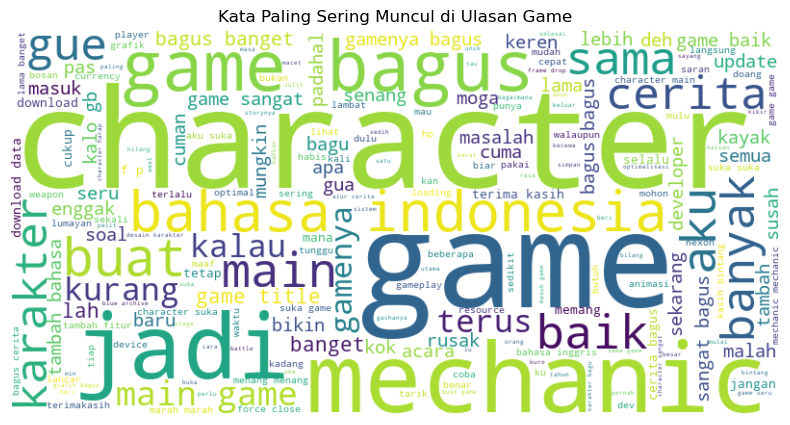

In [9]:
# Gabungkan semua teks jadi satu string raksasa
all_text = " ".join(df_final['text_final'])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plotting
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Kata Paling Sering Muncul di Ulasan Game")
plt.show()